In [2]:
#Imports
#exploration, cleaning
import pandas as pd, numpy as np, matplotlib.pyplot as plt 
from datetime import datetime

#predictions
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
# I renamed the csv files to make them easier to work with
features = pd.read_csv('data/features.csv')
stores = pd.read_csv('data/stores.csv')
sales = pd.read_csv('data/sales.csv')


## Cleaning the features data set

In [4]:
 # I made this function to quickly describe the data since we are working with 3 data sets
def quickDescribe(df):
    print('\n', '##Example##\n' , df.sample(n=5))
    print('\n', '##Shape', df.shape )
    print('\n', '##stats##\n', df.describe())
    print('\n', '##datatypes##\n', df.info()) # for some reason the ##datatype## is below the the df.info output?
    print('\n', '##nulls##\n' , df.isnull().sum())
quickDescribe(features)


 ##Example##
       Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
2944     17  17/09/2010        58.53       2.875        NaN        NaN   
2556     15  02/04/2010        45.27       2.957        NaN        NaN   
8167     45  22/02/2013        31.48       3.859   10781.51    2735.67   
4497     25  27/07/2012        72.98       3.647    6287.52     582.48   
4082     23  05/08/2011        69.53       3.903        NaN        NaN   

      MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
2944        NaN        NaN        NaN  126.145467         6.697      False  
2556        NaN        NaN        NaN  131.901968         8.185      False  
8167      23.38    1516.76    3061.21  193.032822         8.625      False  
4497       2.07    2505.39    1521.67  214.738243         7.280      False  
4082        NaN        NaN        NaN  136.054032         4.584      False  

 ##Shape (8190, 12)

 ##stats##
              Store  Temperature   Fuel_Price

In [5]:
# DateTime Conversion
features['Date'] = pd.to_datetime(features['Date'], dayfirst=True) 
features['Date'].dtype == 'datetime64[ns]'

True

In [6]:
missing_CPI_Dates = features['Date'].loc[features['CPI'].isnull()]  # Examining Identified nulls
print(missing_CPI_Dates.groupby(missing_CPI_Dates.dt.year).count(),  missing_CPI_Dates.groupby(missing_CPI_Dates.dt.month).count())

Date
2013    585
Name: Date, dtype: int64 Date
5    225
6    180
7    180
Name: Date, dtype: int64


In [7]:
# Ive commented out these two approaches, to see which approach gives the best predicitvie accuracy
# the missing values are all from 2013 (The last year of the dataset)
# we should be able to find the real value for these, I was going to fill with the mean, but added a bunch of outliers to 2013
features['CPI'] = features['CPI'].fillna(features.loc[features['Date'].dt.year == 2013 ]['CPI'].mean())
# # I will do the same for the unemployment column
# features['Unemployment'] = features['Unemployment'].fillna(features['Unemployment'].mean())
# Since they are both from 2013, we may end up dropping the whole year from the data set
# features = features.dropna() # I decided to drop the whole year since it is only 3 rows of data]
# sales = sales.dropna() # I decided to drop the whole year since it is only 3 rows of data



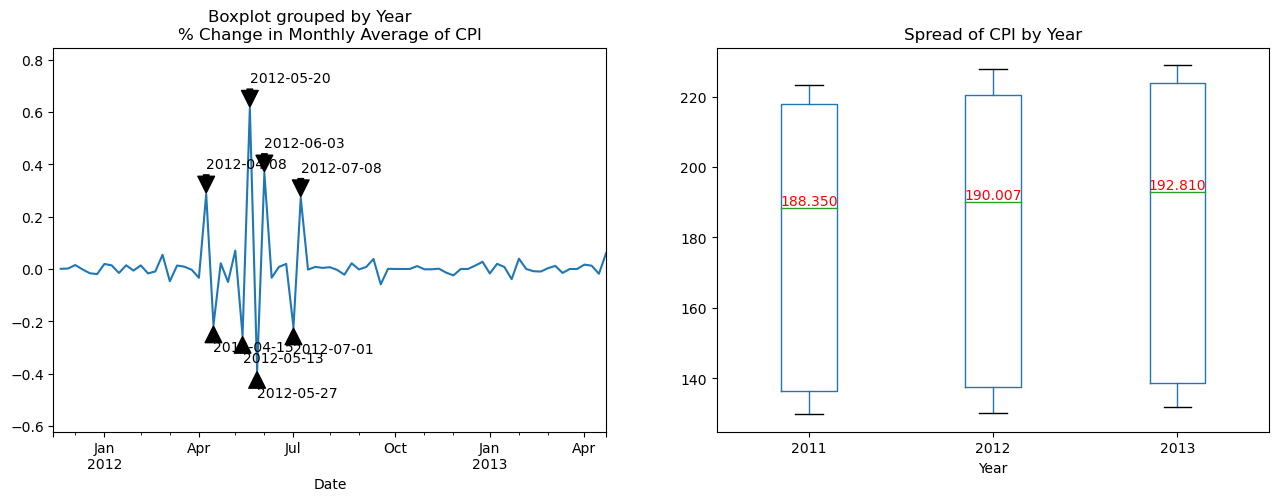

In [8]:
fig, axs = plt.subplots(1,2)

droppedFeatures = features.dropna()
cpi = droppedFeatures['CPI']
cpi_dates = droppedFeatures['Date']

graphDF = pd.DataFrame({'CPI': cpi, 'Date': cpi_dates})
graphDF = graphDF.set_index('Date')

groupedChange = graphDF.groupby(pd.Grouper(freq="W")).mean().pct_change()
groupedChange

grouped_data = graphDF.groupby(graphDF.index.year)



fig1 = groupedChange.plot(kind='line',
                           ylim=(groupedChange['CPI'].min() - groupedChange['CPI'].std()*2, groupedChange['CPI'].max() + groupedChange['CPI'].std()*2),
                             ax=axs[0], title='% Change in Monthly Average of CPI', legend=False)

#set an annotation of the date if the change is greater than 0.1
for i in range(len(groupedChange)):
    if groupedChange.iloc[i]['CPI'] > 0.1:
        fig1.annotate(groupedChange.index[i].strftime('%Y-%m-%d'), xy=(groupedChange.index[i], groupedChange.iloc[i]['CPI']), xytext=(groupedChange.index[i], groupedChange.iloc[i]['CPI'] + 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),)
    if groupedChange.iloc[i]['CPI'] < -0.1:
        fig1.annotate(groupedChange.index[i].strftime('%Y-%m-%d'), xy=(groupedChange.index[i], groupedChange.iloc[i]['CPI']), xytext=(groupedChange.index[i], groupedChange.iloc[i]['CPI'] - 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),)
        
    

df = pd.DataFrame({'CPI': cpi, 'Date': cpi_dates})
df['Date'] = pd.to_datetime(df['Date']).dt.year
df.rename(columns={'Date': 'Year'}, inplace=True)
fig2 = df.boxplot(by='Year', column='CPI', figsize=(12,8), ax=axs[1], grid=False)
fig2.set_title('Spread of CPI by Year')

## setting label
i = 0
for year in df['Year'].unique():
  median_value = df['CPI'].loc[df['Year'] == year].median()
  text_x = fig2.get_xticks()[i]
  text_y = median_value
  i += 1
  axs[1].text(text_x, text_y, f'{median_value:.3f}', color='r', ha='center', va='bottom')

plt.subplots_adjust(bottom=0.1, right=2,)
plt.show()

# Thanks to:
# https://stackoverflow.com/a/16393023 
# https://stackoverflow.com/a/45229527

## Samples Dataset

In [9]:
sales.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
65144,7,52,01/06/2012,1453.79,False
253058,26,51,07/01/2011,91.68,False
63178,7,32,13/08/2010,5392.01,False
168247,18,7,08/04/2011,27466.63,False
162896,17,42,06/05/2011,4131.21,False


<h3> Examining The top, bottom stores

In [10]:
#merging sales, stores
sales_with_stores = pd.merge(stores, sales, on='Store', how='outer')
quickDescribe(sales_with_stores)


 ##Example##
         Store Type    Size  Dept        Date  Weekly_Sales  IsHoliday
208331     22    B  119557     9  04/03/2011      15451.95      False
411447     44    C   39910    95  14/10/2011      28268.32      False
353566     37    C   39910    97  12/10/2012      14978.93      False
421219     45    B  118221    95  24/06/2011      58541.70      False
322155     34    A  158114    12  31/12/2010       4379.05       True

 ##Shape (421570, 7)

 ##stats##
                Store           Size           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000  421570.000000
mean       22.200546  136727.915739      44.260317   15981.258123
std        12.785297   60980.583328      30.492054   22711.183519
min         1.000000   34875.000000       1.000000   -4988.940000
25%        11.000000   93638.000000      18.000000    2079.650000
50%        22.000000  140167.000000      37.000000    7612.030000
75%        33.000000  202505.000000      74.000000   20205.852500
ma

In [11]:
#extracting year 
sales_with_stores['year'] = sales['Date'].apply(lambda x: x[-4:])
sales_with_stores.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,year
0,1,A,151315,1,05/02/2010,24924.50,False,2010
1,1,A,151315,1,12/02/2010,46039.49,True,2010
2,1,A,151315,1,19/02/2010,41595.55,False,2010
3,1,A,151315,1,26/02/2010,19403.54,False,2010
4,1,A,151315,1,05/03/2010,21827.90,False,2010


In [12]:
#determining the change by year and preparing for graph
stores_by_year = sales_with_stores.groupby(['year', 'Store'])['Weekly_Sales'].sum().reset_index()
stores_by_year = stores_by_year.merge(stores[["Store", 'Type']], how='left', on='Store')

stores_by_year['pct_change'] = stores_by_year.groupby('Store')['Weekly_Sales'].pct_change().fillna(0)
stores_by_year.merge(stores[["Store" ,'Type']], how='left', on='Store')

stores_by_year.tail(10)
stores_by_year.loc[stores_by_year['pct_change']  > 0, 'graph_color'] = "green"
stores_by_year.loc[stores_by_year['pct_change']  == 0, 'graph_color'] = "blue"
stores_by_year.loc[stores_by_year['pct_change']  < 0, 'graph_color'] = "red"
quickDescribe(stores_by_year)


 ##Example##
      year  Store  Weekly_Sales Type  pct_change graph_color
133  2012     44   14187373.72    C   -0.084579         red
51   2011      7   30662640.52    B    0.199255       green
39   2010     40   46357359.52    A    0.000000        blue
103  2012     14   77441398.26    A   -0.270084         red
8    2010      9   25129219.76    B    0.000000        blue

 ##Shape (135, 6)

 ##stats##
             Store  Weekly_Sales  pct_change
count  135.000000  1.350000e+02  135.000000
mean    23.000000  4.990533e+07   -0.034659
std     13.035543  2.636476e+07    0.115167
min      1.000000  1.143555e+07   -0.299703
25%     12.000000  2.696103e+07   -0.157805
50%     23.000000  4.635736e+07    0.000000
75%     34.000000  6.795558e+07    0.035948
max     45.000000  1.110923e+08    0.202134
<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 134
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ye

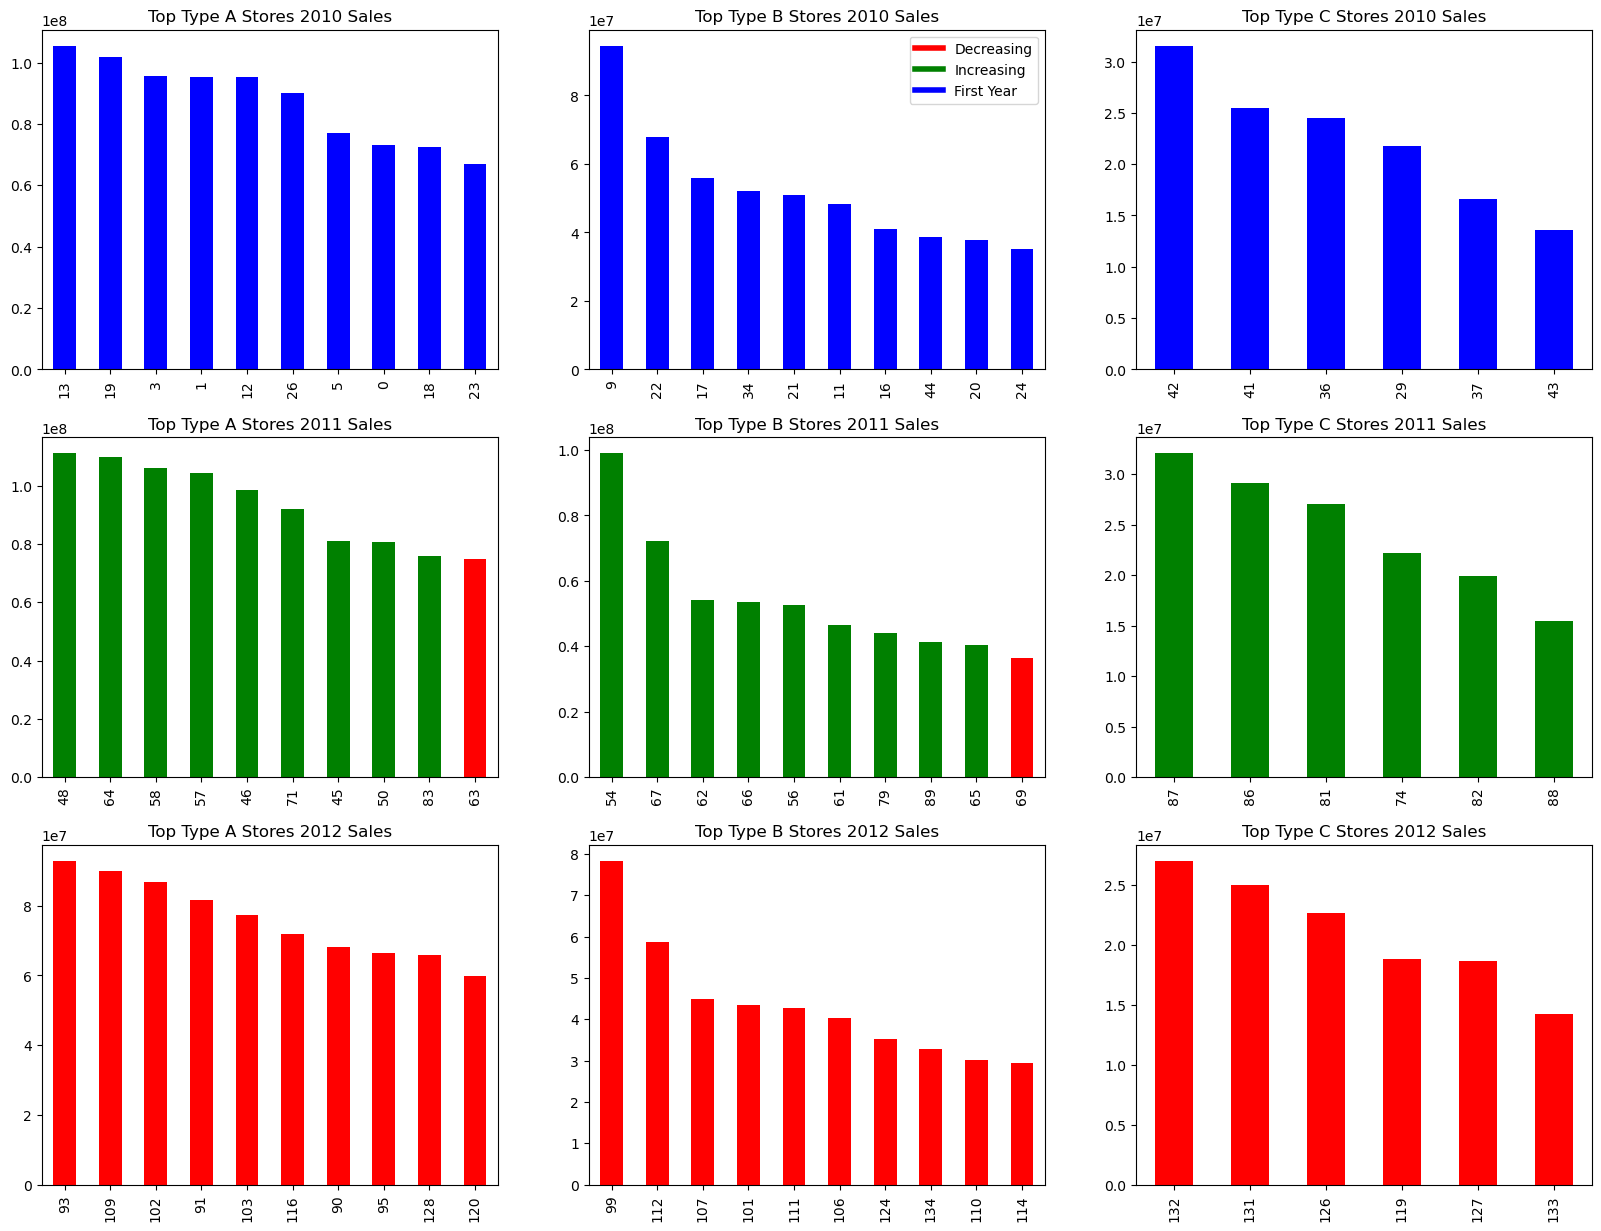

In [13]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(20, 15)
i=2
for i, year in enumerate(stores_by_year['year'].unique()):
    # print(i, year)
    fig1 = stores_by_year.loc[(stores_by_year['Type'] == 'A') & (stores_by_year['year'] == year) ].sort_values(by='Weekly_Sales', ascending=False).head(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,0], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Top Type A Stores {year} Sales", legend=None)
    fig2 = stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)].sort_values(by='Weekly_Sales', ascending=False).head(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,1], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Top Type B Stores {year} Sales", legend=None)
    fig3 = stores_by_year.loc[(stores_by_year['Type'] == 'C') & (stores_by_year['year'] == year) ].sort_values(by='Weekly_Sales', ascending=False).head(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,2], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Top Type C Stores {year} Sales", legend=False)
    from matplotlib.lines import Line2D
    legend_elements = [

    Line2D([0], [0], color='red', lw=4, label='Decreasing'),
    Line2D([0], [0], color='green', lw=4, label='Increasing'),
    Line2D([0], [0], color='Blue', lw=4, label='First Year')
    ]
    axs[0,1].legend(handles=legend_elements, loc='best')


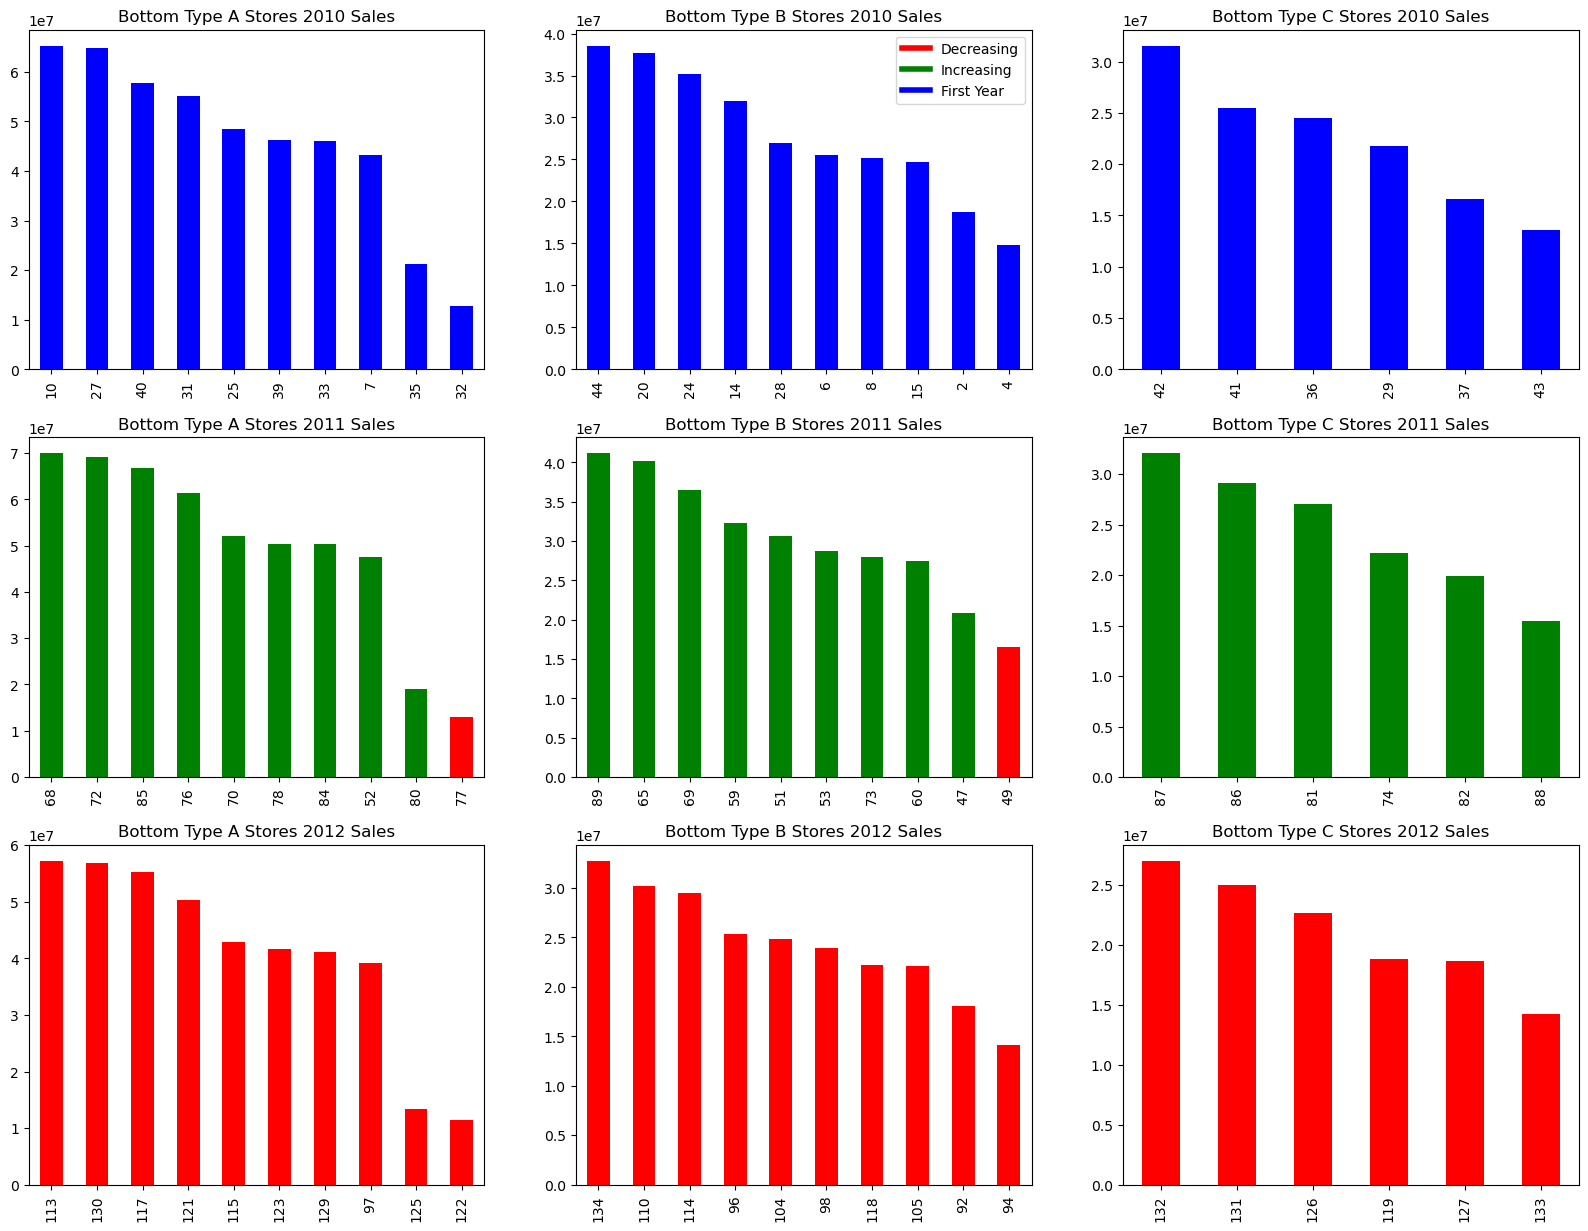

In [14]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(20, 15)
i=2
for i, year in enumerate(stores_by_year['year'].unique()):
    # print(i, year)
    fig1 = stores_by_year.loc[(stores_by_year['Type'] == 'A') & (stores_by_year['year'] == year) ].sort_values(by='Weekly_Sales', ascending=False).tail(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,0], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Bottom Type A Stores {year} Sales", legend=None)
    fig2 = stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)].sort_values(by='Weekly_Sales', ascending=False).tail(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,1], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Bottom Type B Stores {year} Sales", legend=None)
    fig3 = stores_by_year.loc[(stores_by_year['Type'] == 'C') & (stores_by_year['year'] == year) ].sort_values(by='Weekly_Sales', ascending=False).tail(10).plot(
        kind = 'bar', y='Weekly_Sales', ax=axs[i,2], color=stores_by_year.loc[(stores_by_year['Type'] == 'B') & (stores_by_year['year'] == year)]['graph_color'],
          title=f"Bottom Type C Stores {year} Sales", legend=False)
    from matplotlib.lines import Line2D
    legend_elements = [

    Line2D([0], [0], color='red', lw=4, label='Decreasing'),
    Line2D([0], [0], color='green', lw=4, label='Increasing'),
    Line2D([0], [0], color='Blue', lw=4, label='First Year')
    ]
    axs[0,1].legend(handles=legend_elements, loc='best')


In [15]:
# I converted the date column to datetime format
sales['Date'] = [datetime.strptime(date, '%d/%m/%Y') for date in sales['Date']] 
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [16]:
#making a new copy for the next graph
salesViZ = sales 
salesViZ['Date'] = pd.to_datetime(salesViZ['Date'])


In [17]:
 #function to use  in "apply"
def is_pre_holiday(date):
    for key, value in timeDict.items():
        # Check if the date falls within the same week as the holiday
        if date > value and date < key:
            return True
    return False


In [18]:
  #applying the "Pre-holiday check to the dates"
holidays = salesViZ[salesViZ['IsHoliday'] == True]
holiday_dates = holidays['Date'].unique()
high_priority_dates = []
for date in holiday_dates:
    four_weeks_before_holiday = date - pd.DateOffset(weeks=4)
    high_priority_dates.append(np.datetime64(four_weeks_before_holiday))
    
zipped = zip(holiday_dates, high_priority_dates)
timeDict = dict(zipped)

salesViZ['pre_holiday'] = salesViZ['Date'].apply(is_pre_holiday)
salesViZ.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday
0,1,1,2010-02-05,24924.50,False,True
1,1,1,2010-02-12,46039.49,True,False
2,1,1,2010-02-19,41595.55,False,False
3,1,1,2010-02-26,19403.54,False,False
4,1,1,2010-03-05,21827.90,False,False


In [19]:
# Set the holiday status based on the encoded values
salesViZ['Holiday_Status'] = ''

salesViZ.loc[(salesViZ['IsHoliday'] == True) & (salesViZ['pre_holiday'] == True), 'Holiday_Status'] = 'Holiday'
salesViZ.loc[(salesViZ['IsHoliday'] == True) & (salesViZ['pre_holiday'] == False), 'Holiday_Status'] = 'Holiday'
salesViZ.loc[(salesViZ['IsHoliday'] == False) & (salesViZ['pre_holiday'] == True), 'Holiday_Status'] = 'Pre-Holiday'
salesViZ.loc[(salesViZ['IsHoliday'] == False) & (salesViZ['pre_holiday'] == False), 'Holiday_Status'] = 'Non-Holiday'

salesViZ.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status
0,1,1,2010-02-05,24924.50,False,True,Pre-Holiday
1,1,1,2010-02-12,46039.49,True,False,Holiday
2,1,1,2010-02-19,41595.55,False,False,Non-Holiday
3,1,1,2010-02-26,19403.54,False,False,Non-Holiday
4,1,1,2010-03-05,21827.90,False,False,Non-Holiday


In [20]:
 #summing the sales per holiday status, week
weeklysales = salesViZ.groupby(['Date', 'Holiday_Status']).sum()['Weekly_Sales'].reset_index() 
weeklysales.head()

,Date,Holiday_Status,Weekly_Sales
0,2010-02-05,Pre-Holiday,49750740.50
1,2010-02-12,Holiday,48336677.63
2,2010-02-19,Non-Holiday,48276993.78
3,2010-02-26,Non-Holiday,43968571.13
4,2010-03-05,Non-Holiday,46871470.30


In [21]:
weeklysales.head()
pivotsales = weeklysales.pivot(index='Date', columns='Holiday_Status', values='Weekly_Sales')
pivotsales.head()

Holiday_Status,Holiday,Non-Holiday,Pre-Holiday
Date,,,
2010-02-05,NaN,NaN,49750740.5
2010-02-12,48336677.63,NaN,NaN
2010-02-19,NaN,48276993.78,NaN
2010-02-26,NaN,43968571.13,NaN
2010-03-05,NaN,46871470.30,NaN


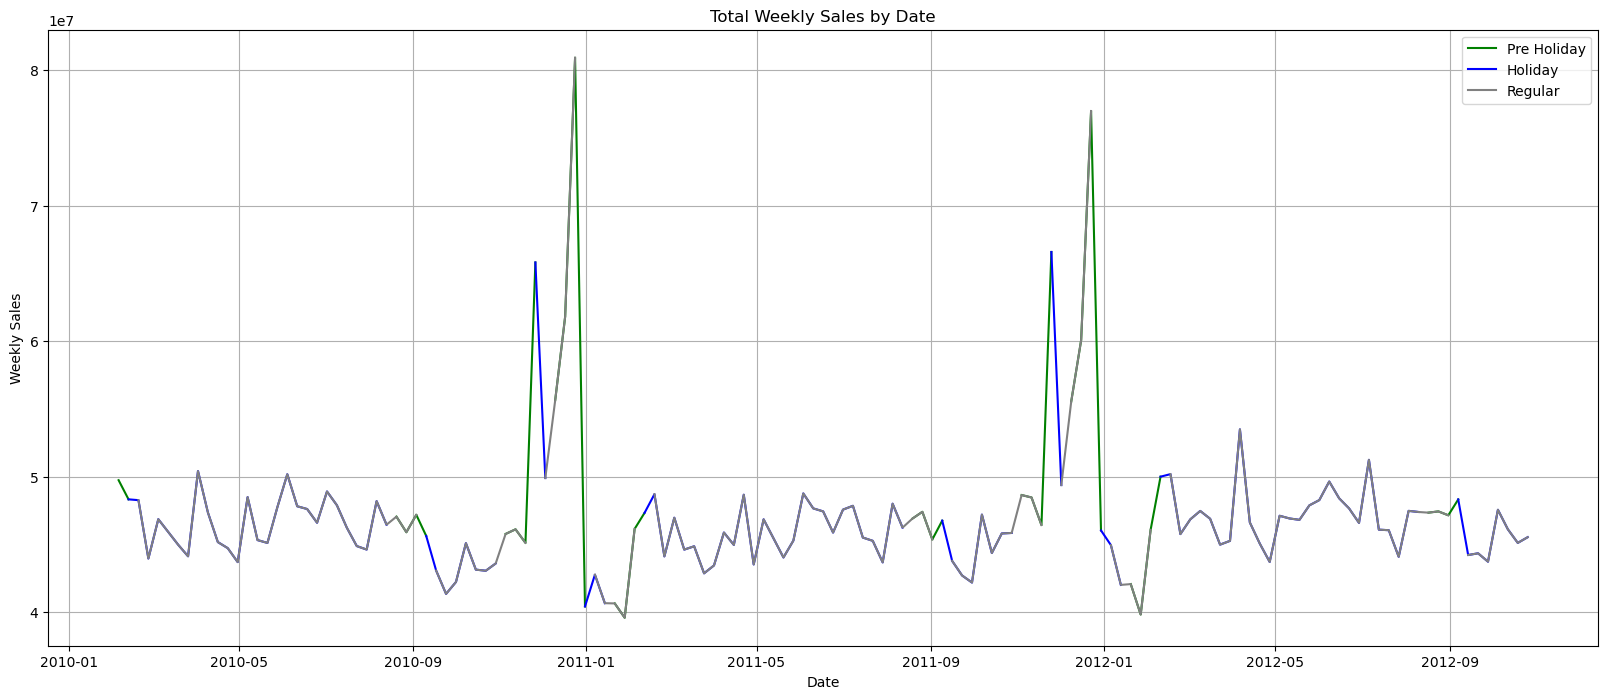

In [22]:
#plotting the sales and holiday status
fig, ax = plt.subplots(figsize=(20, 8))

pholiday = np.ma.masked_where(weeklysales['Holiday_Status'] == 'Pre-Holiday', weeklysales['Weekly_Sales'])
holiday = np.ma.masked_where(weeklysales['Holiday_Status'] == 'Holiday', weeklysales['Weekly_Sales'])
regular = np.ma.masked_where(weeklysales['Holiday_Status'] == 'Non-Holiday', weeklysales['Weekly_Sales'])

ax.plot(weeklysales['Date'], regular, color='Green', label='Pre Holiday')
ax.plot(weeklysales['Date'], pholiday, color='blue', label='Holiday')
ax.plot(weeklysales['Date'], holiday, color='grey', label='Regular')

ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')
ax.set_title('Total Weekly Sales by Date')
ax.grid(True)
ax.legend()


plt.show()


<h2> Predictive Modeling

In [23]:
sales_cleaned = sales#.loc[sales['Date'].dt.year != 2012].loc[sales['Date'].dt.month != 5].loc[sales['Date'].dt.month != 6] I was going to get rid of these due to missing cpi, but decided against it
features_cleaned = features#.loc[features['Date'].dt.year != 2012].loc[features['Date'].dt.month != 5].loc[features['Date'].dt.month != 6]
features_cleaned['CPI'].fillna(features_cleaned['CPI'].mean(), inplace=True) # I filled the missing values with the mean

In [24]:
# lets join the features and sales data sets on the store and date columns
sales_features = pd.merge(sales_cleaned, features_cleaned, on=['Store', 'Date'], how='inner')
sales_features.info() # I checked to see if the merge was successful

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           421570 non-null  int64         
 1   Dept            421570 non-null  int64         
 2   Date            421570 non-null  datetime64[ns]
 3   Weekly_Sales    421570 non-null  float64       
 4   IsHoliday_x     421570 non-null  bool          
 5   pre_holiday     421570 non-null  bool          
 6   Holiday_Status  421570 non-null  object        
 7   Temperature     421570 non-null  float64       
 8   Fuel_Price      421570 non-null  float64       
 9   MarkDown1       150681 non-null  float64       
 10  MarkDown2       111248 non-null  float64       
 11  MarkDown3       137091 non-null  float64       
 12  MarkDown4       134967 non-null  float64       
 13  MarkDown5       151432 non-null  float64       
 14  CPI             421570 non-null  flo

In [25]:
sales_features.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
30718,4,37,2010-05-28,3986.42,False,False,Non-Holiday,67.73,2.756,NaN,NaN,NaN,NaN,NaN,126.160226,7.896,False
230106,24,35,2010-12-17,3173.00,False,True,Pre-Holiday,27.99,3.301,NaN,NaN,NaN,NaN,NaN,132.680452,8.275,False
45792,5,34,2011-12-02,4275.81,False,False,Non-Holiday,51.14,3.172,2359.44,4.00,658.01,901.67,24751.93,219.291729,6.300,False
26570,3,41,2011-12-09,896.38,False,True,Pre-Holiday,49.26,3.158,4059.38,6.47,123.42,833.44,3018.08,222.416785,7.197,False
220107,23,16,2010-12-31,5336.83,True,False,Holiday,19.05,3.177,NaN,NaN,NaN,NaN,NaN,132.815032,5.287,True


In [26]:
#because we are going to do some predictions on the sales data, we need to encode the categorical data
sales_features['IsHoliday_x'] = sales_features['IsHoliday_x'].astype(int) # I converted the IsHoliday column to int
sales_features.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True) # I renamed the IsHoliday_x column to IsHoliday
sales_features.drop(columns=['IsHoliday_y'], inplace=True) # I dropped the IsHoliday_y column
sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,0,True,Pre-Holiday,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [27]:
#markdown NaN can be replaced with 0 since markdown is a discount and 0 is no discount
sales_features['MarkDown1'].fillna(0, inplace=True)
for i in range(1,6):
    sales_features['MarkDown'+ str(i)].fillna(0, inplace=True)

sales_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,2,2010-02-05,50605.27,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2,1,3,2010-02-05,13740.12,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
3,1,4,2010-02-05,39954.04,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
4,1,5,2010-02-05,32229.38,0,True,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106


In [28]:
#extracting the holidays
holidays = sales_features[sales_features['IsHoliday'] == True]

In [29]:
#getting the unique dates
holiday_dates = holidays['Date'].unique()
holiday_dates

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [30]:
high_priority_dates = [] # from the kaggle descripion, the 4 weeks leading up to a holiday are deemed "high importance"
for date in holiday_dates:
    four_weeks_before_holiday = date - pd.DateOffset(weeks=4)
    high_priority_dates.append(np.datetime64(four_weeks_before_holiday))
print(high_priority_dates)
zipped = zip(holiday_dates, high_priority_dates)
timeDict = dict(zipped)


[numpy.datetime64('2010-01-15T00:00:00.000000'), numpy.datetime64('2010-08-13T00:00:00.000000'), numpy.datetime64('2010-10-29T00:00:00.000000'), numpy.datetime64('2010-12-03T00:00:00.000000'), numpy.datetime64('2011-01-14T00:00:00.000000'), numpy.datetime64('2011-08-12T00:00:00.000000'), numpy.datetime64('2011-10-28T00:00:00.000000'), numpy.datetime64('2011-12-02T00:00:00.000000'), numpy.datetime64('2012-01-13T00:00:00.000000'), numpy.datetime64('2012-08-10T00:00:00.000000')]


In [31]:
def is_pre_holiday(date): # defining  function to apply
    for key, value in timeDict.items():
        if date >= value and date <= key:
            return 1
    return 0


In [32]:
# adding the tag "is_pre_holiday"  if the date is 4 weeks before a holiday
sales_features['pre_holiday'] = sales_features['Date'].apply(is_pre_holiday)
sales_features.sample(5)


,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
192800,20,58,2011-07-22,3185.00,0,0,Non-Holiday,78.89,3.811,0.0,0.0,0.0,0.0,0.0,208.593702,7.274
92012,10,56,2011-04-08,2193.04,0,0,Non-Holiday,73.03,3.818,0.0,0.0,0.0,0.0,0.0,128.823806,8.494
122238,13,3,2011-04-22,19626.72,0,0,Non-Holiday,47.55,3.655,0.0,0.0,0.0,0.0,0.0,128.955300,7.193
314814,33,55,2010-06-11,54.00,0,0,Non-Holiday,93.52,3.057,0.0,0.0,0.0,0.0,0.0,126.111903,9.849
13758,2,16,2011-01-14,7539.94,0,1,Non-Holiday,33.02,2.983,0.0,0.0,0.0,0.0,0.0,211.117671,8.028


In [33]:
#splitting the date into year, month, and day columns  # we will want keep the date depening on the model type. For this simple lin regress we do not want the date
sales_features['Year'] = sales_features['Date'].dt.year
sales_features['Month'] = sales_features['Date'].dt.month
sales_features['Day'] = sales_features['Date'].dt.day
sales_features.drop(columns=['Date'], inplace=True)
sales_features.sample(5)



,Store,Dept,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day
381661,41,72,36516.80,0,0,Non-Holiday,37.30,2.750,0.00,0.00,0.00,0.00,0.00,189.690101,7.363,2010,4,9
418262,45,10,11466.94,1,1,Holiday,48.71,3.492,140.87,384.82,26961.99,28.59,1110.12,188.350400,8.523,2011,11,25
353825,38,10,278.32,0,0,Non-Holiday,54.83,2.915,0.00,0.00,0.00,0.00,0.00,126.526286,13.975,2010,2,19
88005,10,33,14643.32,0,0,Non-Holiday,61.46,3.054,0.00,0.00,0.00,0.00,0.00,126.606645,9.765,2010,3,19
84562,9,81,2540.84,0,1,Non-Holiday,46.84,3.172,1237.88,0.00,1330.53,643.78,8323.51,222.397544,6.054,2011,12,2


In [34]:
# encoding the year into 1, 2, 3, 4
sales_features['Year'] = sales_features['Year'].map({2010: 1, 2011: 2, 2012: 3, 2013: 4})
sales_features.head()

,Store,Dept,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day
0,1,1,24924.50,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
1,1,2,50605.27,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
2,1,3,13740.12,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
3,1,4,39954.04,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5
4,1,5,32229.38,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,2,5


In [35]:
 #confirming the type 
sales_features['Month'].dtypes == 'int64' and sales_features['Year'].dtypes == 'int64' and sales_features['Day'].dtypes == 'int64'

True

In [36]:
# Encoding the month and days cyclically thanks to http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
# Basicly, we are ploting the month and day onto a "clock" and then using the angle of the clock hand to encode the month and day between -1 and 1 
sales_features['mnth_sin'] = np.sin((sales_features.Month-1)*(2.*np.pi/12))
sales_features['mnth_cos'] = np.cos((sales_features.Month-1)*(2.*np.pi/12))

In [37]:
def day_sin(row): # for applying
    if row['Month'] == 1:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 2:
        return np.sin((row['Day']-1)*(2.*np.pi/28))
    elif row['Month'] == 3:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 4:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 5:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 6:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 7:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 8:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 9:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 10:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 11:
        return np.sin((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 12:
        return np.sin((row['Day']-1)*(2.*np.pi/31))
    else:
        return np.nan

In [38]:
def day_cos(row):   
    if row['Month'] == 1:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 2:
        return np.cos((row['Day']-1)*(2.*np.pi/28)) 
    elif row['Month'] == 3:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 4:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 5:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 6:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 7:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 8:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 9:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 10:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    elif row['Month'] == 11:
        return np.cos((row['Day']-1)*(2.*np.pi/30))
    elif row['Month'] == 12:
        return np.cos((row['Day']-1)*(2.*np.pi/31))
    else:
        return np.nan

In [39]:
sales_features['day_sin'] = sales_features.apply(day_sin, axis=1)
sales_features['day_cos'] = sales_features.apply(day_cos, axis=1) 

In [40]:
# remove the numeric column we encoded
sales_features.drop(columns=['Year', 'Month', 'Day'], inplace=True)
sales_features.head()

,Store,Dept,Weekly_Sales,IsHoliday,pre_holiday,Holiday_Status,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,mnth_sin,mnth_cos,day_sin,day_cos
0,1,1,24924.50,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349
1,1,2,50605.27,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349
2,1,3,13740.12,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349
3,1,4,39954.04,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349
4,1,5,32229.38,0,1,Pre-Holiday,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.5,0.866025,0.781831,0.62349


In [41]:
# remove the categorical column we encoded
sales_features.drop(columns=['Holiday_Status'], inplace=True) 
sales_features.sample(5)

,Store,Dept,Weekly_Sales,IsHoliday,pre_holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,mnth_sin,mnth_cos,day_sin,day_cos
304142,32,11,13502.08,0,0,37.72,2.620,0.00,0.00,0.00,0.00,0.00,189.669505,9.014,0.866025,0.500000,0.724793,0.688967
274217,28,28,577.12,0,1,46.20,3.660,5177.01,1280.59,23.75,716.52,6009.03,130.279226,12.187,0.000000,1.000000,-0.651372,-0.758758
139527,15,24,3496.47,0,0,72.79,2.958,0.00,0.00,0.00,0.00,0.00,132.497600,8.185,0.500000,-0.866025,-0.951057,0.309017
102552,11,49,6933.66,0,0,76.97,3.907,0.00,0.00,0.00,0.00,0.00,219.127216,7.574,0.866025,-0.500000,-0.651372,-0.758758
86782,9,8,21475.80,0,1,88.66,3.494,3180.78,-9.94,1.40,2112.03,2314.58,225.717009,5.277,-0.500000,-0.866025,0.968077,-0.250653


In [42]:
#one hot encoding the store, department numbers
sales_features = pd.get_dummies(sales_features, columns=['Store', 'Dept']) 
sales_features.head()

,Weekly_Sales,IsHoliday,pre_holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,24924.50,0,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,50605.27,0,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,13740.12,0,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,39954.04,0,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,32229.38,0,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
y = sales_features['Weekly_Sales']
X = sales_features.drop(columns=['Weekly_Sales'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the prediction using R-squared score
accuracy = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('accuaracy: ', accuracy, 'mse: ', mse)

accuaracy:  0.6517278747586301 mse:  183095396.226483


In [49]:
# Create a dataframe of the model coefficients  (How important each feature is (higher number = more importance))
coef = pd.DataFrame(list(zip(X.columns, model.coef_)), columns=['Features', 'Coefficients']).sort_values(by='Coefficients', ascending=False)
coef.head(4)

,Features,Coefficients
27,Store_13,4.577193e+13
24,Store_10,4.543196e+13
18,Store_4,4.533954e+13
15,Store_1,4.527924e+13


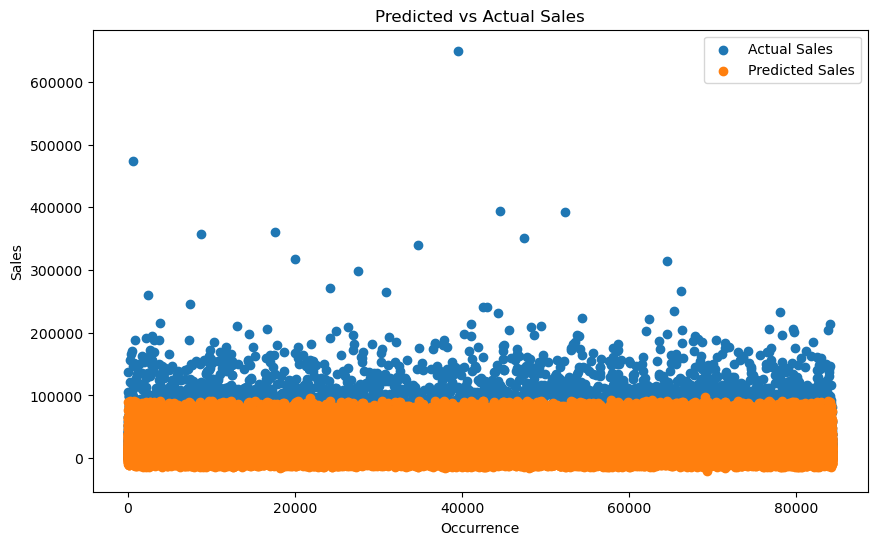

In [50]:
# We dropped the date so we have to plot by occurence instead 

# Generate an array of indices based on the length of y_test
indices = np.arange(len(y_test))

# Plot the predicted vs actual sales values
plt.figure(figsize=(10, 6))
plt.scatter(indices, y_test, label='Actual Sales')
plt.scatter(indices, y_pred, label='Predicted Sales')
plt.xlabel('Occurrence')
plt.ylabel('Sales')
plt.title('Predicted vs Actual Sales')
plt.legend()
plt.show()


<h5> We were looking for accuracy over 75% at least, and a MSE is good the closer it is to 0.
<h5> We could try:
<li> adding more feature engineering (Setting the big 4 to one hot encoded, adding a movign average, ect)
<li> looking for more outliers
<li> trying a different model


<h5> Im going to try breaking my predictions down by store


In [51]:
#predictions per store
summary_rows = []
for store in features['Store'].unique():
    y = sales_features['Weekly_Sales'].loc[sales_features[f'Store_{store}'] == 1]
    X = sales_features.drop(columns=['Weekly_Sales']).loc[sales_features[f'Store_{store}'] == 1]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Evaluate the accuracy of the prediction using R-squared score
    accuracy = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)

    row = store, accuracy, mse
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows, columns=['Store', 'R-squared score', 'Mean Squared Error'])
summary_df.describe()


,Store,R-squared score,Mean Squared Error
count,45.000000,4.500000e+01,4.500000e+01
mean,23.000000,-5.751511e+23,1.095906e+32
std,13.133926,1.852228e+24,3.237773e+32
min,1.000000,-8.719337e+24,1.941076e+06
25%,12.000000,8.202819e-01,1.723715e+07
50%,23.000000,9.043682e-01,4.282570e+07
75%,34.000000,9.328753e-01,8.445995e+07
max,45.000000,9.895771e-01,1.287699e+33


<h4>looks like most of the store predicted ok, and a few were really poor

In [52]:
#stores we predicted poorly 
summary_df.sort_values('R-squared score').head(10)

,Store,R-squared score,Mean Squared Error
24,25,-8.719337e+24,1.287699e+33
20,21,-7.084311e+24,1.256292e+33
35,36,-5.064099e+24,8.820457e+32
16,17,-3.423312e+24,8.708652e+32
22,23,-1.500764e+24,6.163312e+32
37,38,-8.997406e+22,1.834252e+31
14,15,6.863112e-01,4.686564e+07
21,22,7.336026e-01,1.049084e+08
11,12,7.959261e-01,7.008600e+07
34,35,8.003071e-01,5.296227e+07


In [53]:
#stores we predicted well
summary_df.sort_values('R-squared score').head(10)

,Store,R-squared score,Mean Squared Error
24,25,-8.719337e+24,1.287699e+33
20,21,-7.084311e+24,1.256292e+33
35,36,-5.064099e+24,8.820457e+32
16,17,-3.423312e+24,8.708652e+32
22,23,-1.500764e+24,6.163312e+32
37,38,-8.997406e+22,1.834252e+31
14,15,6.863112e-01,4.686564e+07
21,22,7.336026e-01,1.049084e+08
11,12,7.959261e-01,7.008600e+07
34,35,8.003071e-01,5.296227e+07


In [54]:
poor_predictors_removed = pd.DataFrame()
bad_predictors = summary_df.loc[summary_df['R-squared score'] < 0.75]['Store']
for store in bad_predictors:
    sales_features = sales_features.drop(sales_features.loc[sales_features[f'Store_{store}'] == 1].index)

print(f'dropped {len(bad_predictors)} bad predictors')

dropped 8 bad predictors


In [55]:
# Creating a linear regression model
y = sales_features['Weekly_Sales']
X = sales_features.drop(columns=['Weekly_Sales'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f' Accuracy: {accuracy} \n Mean Squared Error: {mse}')
coef = pd.DataFrame(list(zip(X.columns, model.coef_)), columns=['Features', 'Coefficients']).sort_values(by='Coefficients', ascending=False)
coef.head(4)

 Accuracy: 0.6060235280919626 
 Mean Squared Error: 231231921.9667844


,Features,Coefficients
133,Dept_92,1.506594e+17
136,Dept_95,1.506594e+17
98,Dept_40,1.506594e+17
96,Dept_38,1.506594e+17


<h5> Unfortunately, that decreased model performance, lets try some others

<h2> Other Models

In [56]:
# Unimplemented due to runtime
# from sklearn.ensemble import GradientBoostingRegressor

# y = sales_features['Weekly_Sales']
# X = sales_features.drop(columns=['Weekly_Sales'])

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# # Create a Gradient Boosting Regression model
# model = GradientBoostingRegressor()

# # Fit the model on the training data
# model.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = model.predict(X_test)

# # Evaluate the accuracy of the prediction using R-squared score
# accuracy = r2_score(y_test, y_pred)
# print("Gradient Boosting R-squared score:", accuracy)


In [57]:
# Unimplemented due to runtime

# from sklearn.svm import SVR

# y = sales_features['Weekly_Sales']
# X = sales_features.drop(columns=['Weekly_Sales'])

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Create a Support Vector Regression model
# model = SVR()

# # Fit the model on the training data
# model.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = model.predict(X_test)

# # Evaluate the accuracy of the prediction using R-squared score
# accuracy = r2_score(y_test, y_pred)
# print("Support Vector Regression R-squared score:", accuracy)


In [58]:
# # # Unimplemented due to runtime, weird period error

# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# # Extract the target variable as a Series
# sales_data = sales_features.set_index('Date')['Weekly_Sales']
# sales_features = sales_features.asfreq('W')

# # Split the data into training and testing sets
# train_data_length = int(0.8 * len(sales_data))
# train_data = sales_data[:train_data_length]
# test_data = sales_data[train_data_length:]

# # Create and fit the Triple Exponential Smoothing model
# model = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=12)
# model_fit = model.fit()

# # Make predictions
# predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# # Evaluate the model
# accuracy = r2_score(test_data, predictions)
# print("Triple Exponential Smoothing R-squared score:", accuracy[:4])


In [59]:
# # not experienced with the ExponentialSmoothing function, need to ask for help because the above cell says this is false
# sales_features.index.is_monotonic_increasing

In [60]:
newAttempt = salesViZ
newAttempt.drop(columns='Holiday_Status', axis=0)

,Store,Dept,Date,Weekly_Sales,IsHoliday,pre_holiday
0,1,1,2010-02-05,24924.50,False,True
1,1,1,2010-02-12,46039.49,True,False
2,1,1,2010-02-19,41595.55,False,False
3,1,1,2010-02-26,19403.54,False,False
4,1,1,2010-03-05,21827.90,False,False
...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,False
421566,45,98,2012-10-05,628.10,False,False
421567,45,98,2012-10-12,1061.02,False,False
421568,45,98,2012-10-19,760.01,False,False


In [61]:
store_depts = newAttempt.groupby(['Store', 'Dept', 'Date', 'IsHoliday', 'pre_holiday']).sum()
store_depts = store_depts.reset_index()
store_depts.head()

C:\Users\xanen\AppData\Local\Temp\ipykernel_11716\526293773.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  store_depts = newAttempt.groupby(['Store', 'Dept', 'Date', 'IsHoliday', 'pre_holiday']).sum()


,Store,Dept,Date,IsHoliday,pre_holiday,Weekly_Sales
0,1,1,2010-02-05,False,True,24924.50
1,1,1,2010-02-12,True,False,46039.49
2,1,1,2010-02-19,False,False,41595.55
3,1,1,2010-02-26,False,False,19403.54
4,1,1,2010-03-05,False,False,21827.90


In [62]:
store_depts["IsHoliday"] = store_depts["IsHoliday"].astype(int)
store_depts["pre_holiday"] = store_depts["pre_holiday"].astype(int)
store_depts.head()

,Store,Dept,Date,IsHoliday,pre_holiday,Weekly_Sales
0,1,1,2010-02-05,0,1,24924.50
1,1,1,2010-02-12,1,0,46039.49
2,1,1,2010-02-19,0,0,41595.55
3,1,1,2010-02-26,0,0,19403.54
4,1,1,2010-03-05,0,0,21827.90


In [63]:
store1_dept_1 = store_depts.loc[store_depts['Store'] == 1].loc[store_depts['Dept'] == 1]
store1_dept_1

,Store,Dept,Date,IsHoliday,pre_holiday,Weekly_Sales
0,1,1,2010-02-05,0,1,24924.50
1,1,1,2010-02-12,1,0,46039.49
2,1,1,2010-02-19,0,0,41595.55
3,1,1,2010-02-26,0,0,19403.54
4,1,1,2010-03-05,0,0,21827.90
...,...,...,...,...,...,...
138,1,1,2012-09-28,0,0,18947.81
139,1,1,2012-10-05,0,0,21904.47
140,1,1,2012-10-12,0,0,22764.01
141,1,1,2012-10-19,0,0,24185.27


In [64]:
store1_dept_1.set_index('Date')

,Store,Dept,IsHoliday,pre_holiday,Weekly_Sales
Date,,,,,
2010-02-05,1,1,0,1,24924.50
2010-02-12,1,1,1,0,46039.49
2010-02-19,1,1,0,0,41595.55
2010-02-26,1,1,0,0,19403.54
2010-03-05,1,1,0,0,21827.90
...,...,...,...,...,...
2012-09-28,1,1,0,0,18947.81
2012-10-05,1,1,0,0,21904.47
2012-10-12,1,1,0,0,22764.01


In [65]:
df = store1_dept_1

### ARIMA Stands for Autoregressive Integrated Moving Average 

##### Basicly, this should help us fit the curves in the prediction better as we can set the period to week, matching our data

###### https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [67]:
import statsmodels.api as sm

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

# Define the exogenous variables or the variables that have no effect on the model
exog_vars = ['Store', 'Dept']

# Define the model
model = sm.tsa.ARIMA(endog=train_data['Weekly_Sales'],
                     exog=train_data[exog_vars],
                     trend='t'
)

# Fit the model
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1],
                                exog=test_data[exog_vars])

# Evaluate the model
mse = ((predictions - test_data['Weekly_Sales']) ** 2).mean()
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 56977021.48638281


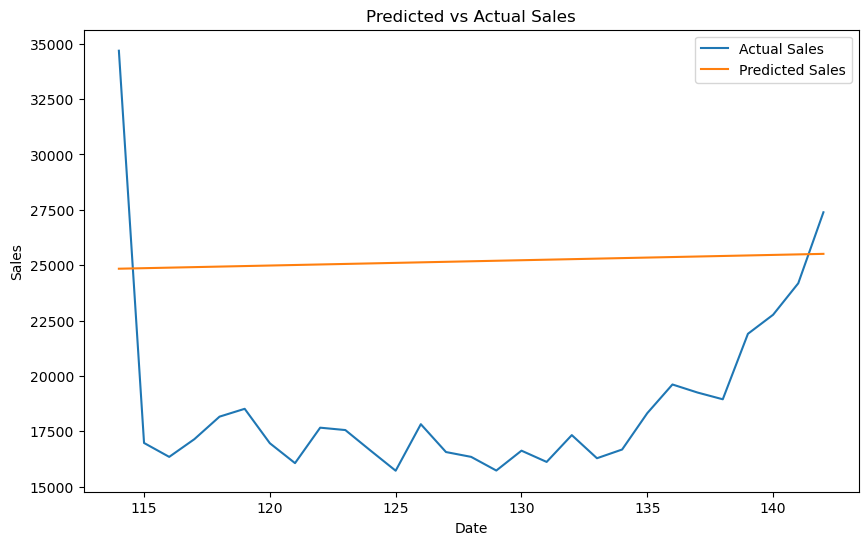

In [68]:
import matplotlib.pyplot as plt


dates = test_data.index
actual_sales = test_data['Weekly_Sales']

plt.figure(figsize=(10, 6))
plt.plot(dates, actual_sales, label='Actual Sales')
plt.plot(dates, predictions, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Predicted vs Actual Sales')
plt.legend()
plt.show()


In [69]:
msefrombefore = 231231921.9667844
percentImprovement = ((msefrombefore - mse )/mse)*100
print(round(percentImprovement, 2), '% Improvement, but still quite a way to go')

305.83 % Improvement, but still quite a way to go


# Facebook Prophet 
### Another Timer Series Based Model, lets try it out!
##### https://facebook.github.io/prophet/


In [101]:
from prophet import Prophet

df = store1_dept_1
df.head()
df = df.reset_index(drop=True).fillna(0)

df_prophet = df[['Date', 'Weekly_Sales']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

train_size = int(len(df_prophet) * 0.8)
train_data = df_prophet[:train_size]
test_data = df_prophet[train_size:]

model = Prophet()
model.fit(train_data)

future = model.make_future_dataframe(periods=len(test_data))
predictions = model.predict(future)

predictions_test = predictions[train_size:][['ds', 'yhat']]

mse = ((predictions_test['yhat'] - test_data['y']) ** 2).mean()
print('*'*15)
print("Mean Squared Error (MSE):", mse)
msefrombefore =  56977021.48638281
percentImprovement = ((msefrombefore - mse )/mse)*100
print(round(percentImprovement, 2), '% Inscrease  in accuracy Prophet vs ARIMA')

04:47:07 - cmdstanpy - INFO - Chain [1] start processing
04:47:07 - cmdstanpy - INFO - Chain [1] done processing


***************
Mean Squared Error (MSE): 200086516.1284111
-71.52 % Inscrease  in accuracy Prophet vs ARIMA


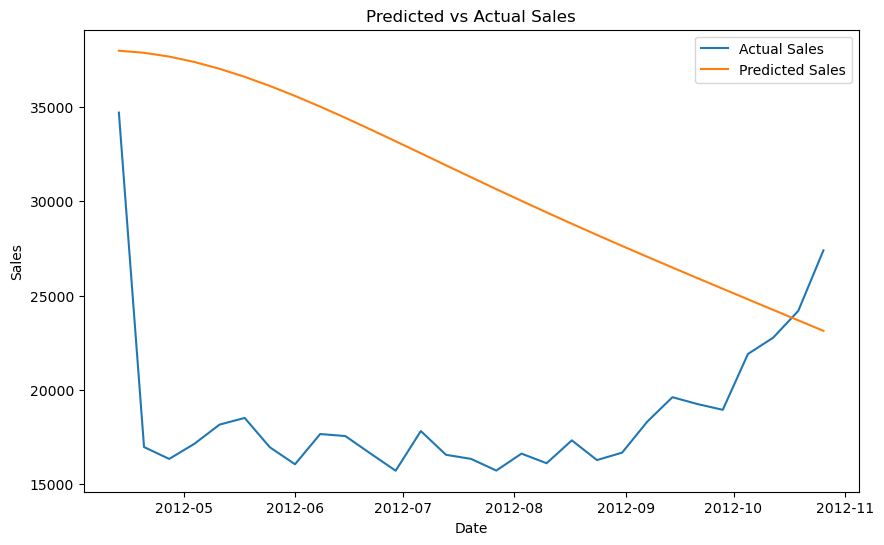

In [102]:
dates = test_data['ds']
actual_sales = test_data['y']

predicted_sales = predictions_test['yhat']

plt.figure(figsize=(10, 6))
plt.plot(dates, actual_sales, label='Actual Sales')
plt.plot(dates, predicted_sales, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Predicted vs Actual Sales')
plt.legend()
plt.show()


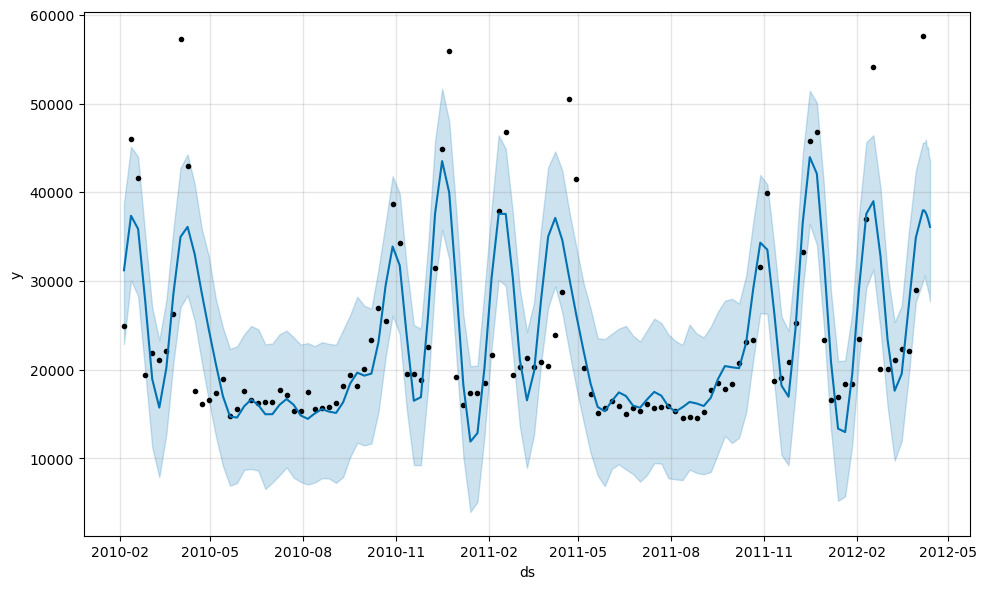

In [103]:
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)
fig1 = model.plot(forecast)

#### The prediction (Blue Line) actually fits our data (Black Dots) now. 
#### Next step is to reduce uncertainty (Shaded Area Shoudd be close to line)  

#### BUT Im suprised my graph and the predictions graph have such different shapes... #TODO figure out whats going on there.


In [104]:
holiday_dates ##Attempting to add holday parameters

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [106]:
from prophet import Prophet

df = store1_dept_1
df.head()
df = df.reset_index(drop=True).fillna(0)

df_prophet = df[['Date', 'Weekly_Sales']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

train_size = int(len(df_prophet) * 0.8)
train_data = df_prophet[:train_size]
test_data = df_prophet[train_size:]

model = Prophet(holidays=pd.DataFrame({
    'holiday': ['superbowl', 'laborday', 'thanksgiving', 'newyears', 'superbowl', 'laborday', 'thanksgiving', 'newyears', 'superbowl', 'laborday'], #hand coded ugh
    'ds': pd.to_datetime(holiday_dates)
}))
model.fit(train_data)

future = model.make_future_dataframe(periods=len(test_data))
predictions = model.predict(future)

predictions_test = predictions[train_size:][['ds', 'yhat']]

mse = ((predictions_test['yhat'] - test_data['y']) ** 2).mean()
print("Mean Squared Error (MSE):", mse)
msefrombefore =  200086516.1284111
percentImprovement = ((msefrombefore - mse )/mse)*100
print(round(percentImprovement, 2), '% Increase in Accuracy Adding Holidays')

04:49:00 - cmdstanpy - INFO - Chain [1] start processing
04:49:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 203072353.23613194
-1.47 % Increase in Accuracy Adding Holidays


In [110]:
df = store1_dept_1
df.head()
df = df.reset_index(drop=True).fillna(0)

df_prophet = df[['Date', 'Weekly_Sales']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

train_size = int(len(df_prophet) * 0.8)
train_data = df_prophet[:train_size]
test_data = df_prophet[train_size:]

model = Prophet(
    seasonality_mode='multiplicative'
)
model.fit(train_data)

future = model.make_future_dataframe(periods=len(test_data))
predictions = model.predict(future)

predictions_test = predictions[train_size:][['ds', 'yhat']]

mse = ((predictions_test['yhat'] - test_data['y']) ** 2).mean()
print('*'*15)
print("Mean Squared Error (MSE):", mse)
msefrombefore =  200086516.1284111
percentImprovement = ((msefrombefore - mse )/mse)*100
print(round(percentImprovement, 2), '% Increase in accuracy adding Multiplicitive Seasonality (No Holidays)')

04:53:09 - cmdstanpy - INFO - Chain [1] start processing
04:53:09 - cmdstanpy - INFO - Chain [1] done processing


***************
Mean Squared Error (MSE): 193384850.28098163
3.47 % Increase in accuracy adding Multiplicitive Seasonality (No Holidays)


04:53:45 - cmdstanpy - INFO - Chain [1] start processing
04:53:45 - cmdstanpy - INFO - Chain [1] done processing


***************
Mean Squared Error (MSE): 199945836.40809116
-3.28 % Increase in accuracy adding Prophet US Holidays


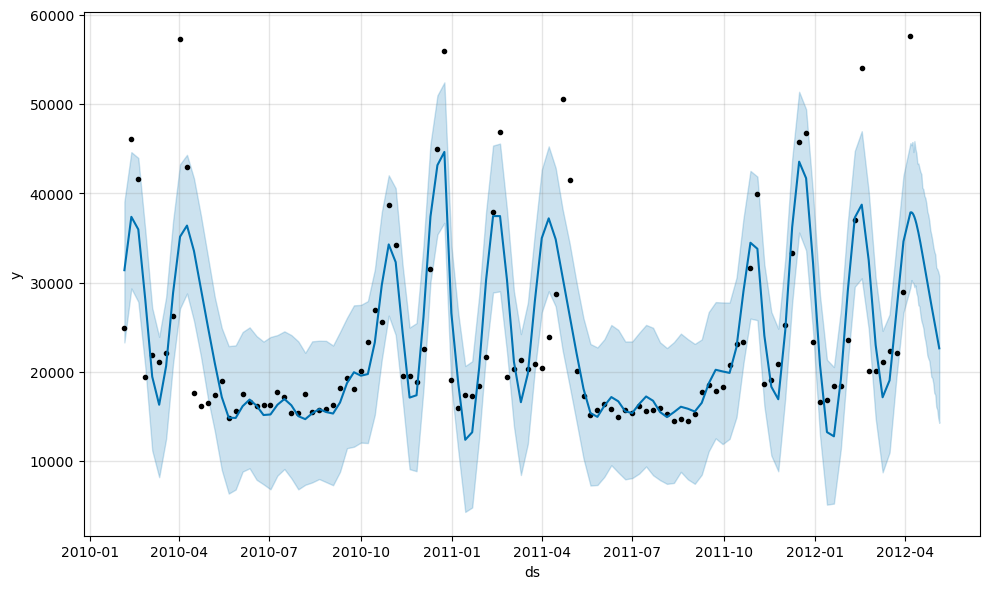

In [111]:
df = store1_dept_1
df.head()
df = df.reset_index(drop=True).fillna(0)

df_prophet = df[['Date', 'Weekly_Sales']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

train_size = int(len(df_prophet) * 0.8)
train_data = df_prophet[:train_size]
test_data = df_prophet[train_size:]

model = Prophet(
    seasonality_mode='multiplicative',
)
model.add_country_holidays(country_name='US') #should have read the full example first, this is so much better

model.fit(train_data)

future = model.make_future_dataframe(periods=len(test_data))
predictions = model.predict(future)

predictions_test = predictions[train_size:][['ds', 'yhat']]
print('*'*15)

mse = ((predictions_test['yhat'] - test_data['y']) ** 2).mean()
print("Mean Squared Error (MSE):", mse)



msefrombefore = 193384850.28098163
percentImprovement = ((msefrombefore - mse )/mse)*100
print(round(percentImprovement, 2), '% Increase in accuracy adding Prophet US Holidays')

fig1 = model.plot(predictions)

04:54:08 - cmdstanpy - INFO - Chain [1] start processing
04:54:08 - cmdstanpy - INFO - Chain [1] done processing


***************
Mean Squared Error (MSE): 185948081.3304026
4.0 % Accuracy Increace reducing the intensity of the holiday effect to "4" from "10"


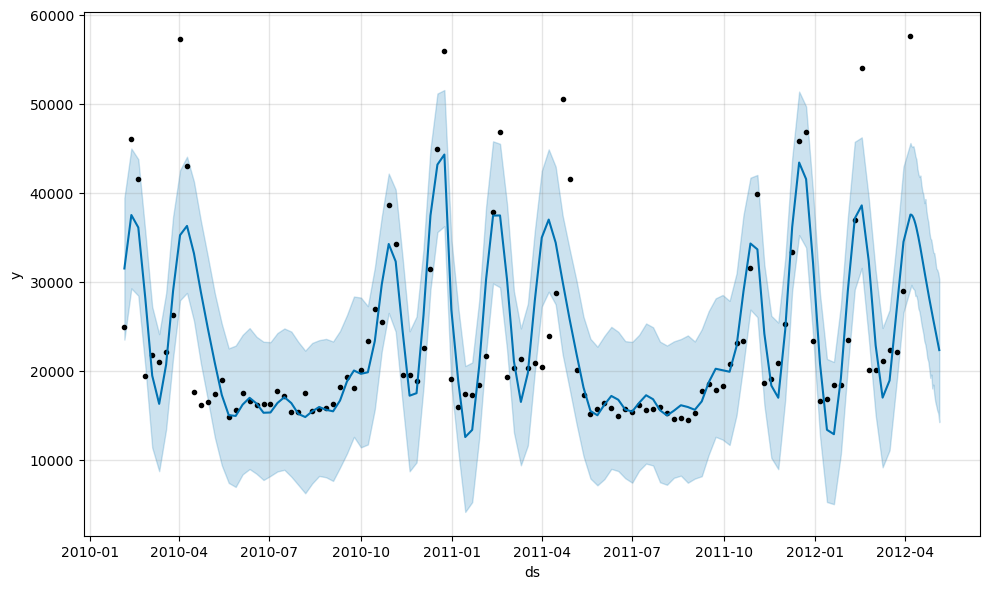

In [112]:
df = store1_dept_1
df.head()
df = df.reset_index(drop=True).fillna(0)

df_prophet = df[['Date', 'Weekly_Sales']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

train_size = int(len(df_prophet) * 0.8)
train_data = df_prophet[:train_size]
test_data = df_prophet[train_size:]

model = Prophet(
    seasonality_mode='multiplicative',
    holidays_prior_scale = 4
)
model.add_country_holidays(country_name='US')

model.fit(train_data)

future = model.make_future_dataframe(periods=len(test_data))
predictions = model.predict(future)

predictions_test = predictions[train_size:][['ds', 'yhat']]

mse = ((predictions_test['yhat'] - test_data['y']) ** 2).mean()
print('*'*15)

print("Mean Squared Error (MSE):", mse)


msefrombefore = 193384850.28098163
percentImprovement = ((msefrombefore - mse )/mse)*100
print(round(percentImprovement, 2), '% Accuracy Increace reducing the intensity of the holiday effect to "4" from "10"')

fig1 = model.plot(predictions)

<h3> Comparing the Non-Holiday Mulitplicitive, vs this last approach we are only +0.4% accuracy, so more work needs to be done  